In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split # for testing purposes

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


# Part 1: EDA
Load and explore the data set.

In [2]:
# Load the training data set
train_df = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
train_df.head()
# train_df.info()
# train_df.describe()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


**Look for missing data and its percentage of overall data.**

In [3]:
percentage_of_missing = ( train_df.isnull().sum() / train_df.count() * 100)
percentage_of_missing

PassengerId     0.000000
HomePlanet      2.366934
CryoSleep       2.560170
Cabin           2.342830
Destination     2.138409
Age             2.102420
VIP             2.391048
RoomService     2.126410
FoodCourt       2.150411
ShoppingMall    2.451385
Spa             2.150411
VRDeck          2.210464
Name            2.354880
Transported     0.000000
dtype: float64

**The missing data is less than 3% for all the columns, so we can fill most likely.**

Next:
Check for totally unique columns that can be omitted

In [4]:
train_df.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

In [5]:
train_df.isnull().sum() 

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

**PassengerID is totally unique (as expected) so it can be dropped from training set.**

**Names are nearly unique but lets check on them a bit more.**

In [6]:
# List out the duplicated names
tmp  = set()
dups = pd.DataFrame(set(x for x in train_df['Name'] if (x in tmp or tmp.add(x))))
print(dups.dropna())
len(dups.dropna())

                     0
1   Ankalik Nateansive
2    Juane Popelazquez
3     Glenna Valezaley
4          Anton Woody
5       Gollux Reedall
6     Carry Contrevins
7         Keitha Josey
8   Alraium Disivering
9            Apix Wala
10    Troya Schwardson
11          Sus Coolez
12   Glena Hahnstonsen
13       Asch Stradick
14       Gwendy Sykess
15     Loree Wolfernan
16          Dia Cartez
17     Sharie Gallenry
18         Cuses Pread
19  Elaney Webstephrey
20         Grake Porki


20

**There are 20 names that appear more than once on the dataframe. Thats a small number so I will allow that and still remove 'Name' from the dataset for training.**

In [7]:
# drop 'PassengerId' and 'Name' from data set
train_df_clean = train_df.drop(columns = ['PassengerId', 'Name'])
train_df_clean.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


## Explore data with Visualization 

In [8]:
train_df.columns[7:12]

Index(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], dtype='object')

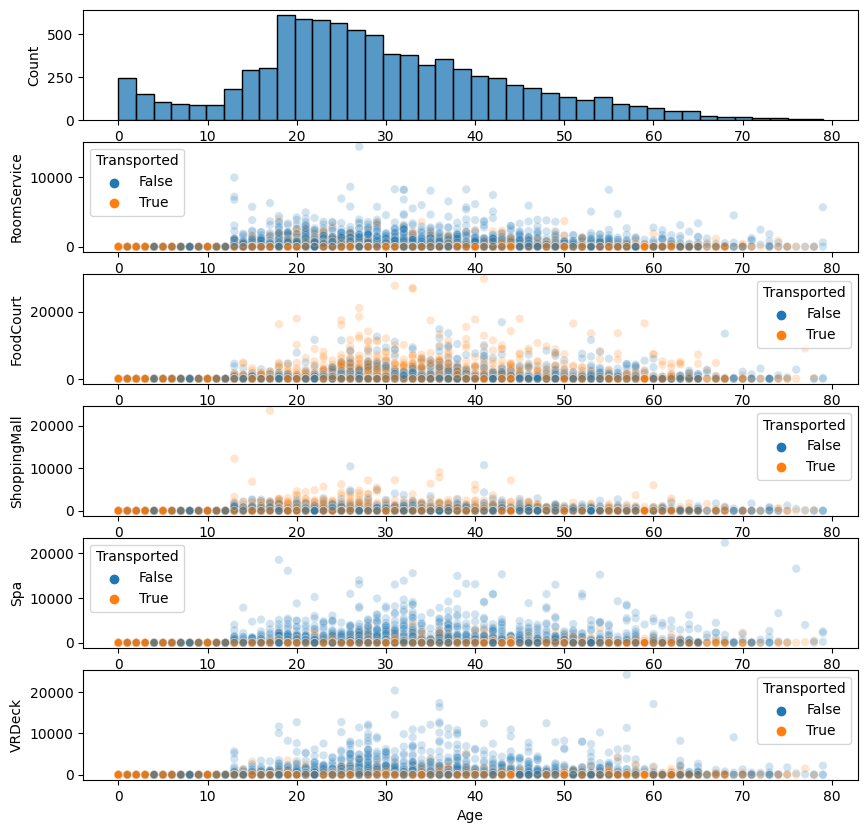

In [9]:
figure, ax = plt.subplots(6,1, figsize=(10,10))
sns.histplot(train_df_clean['Age'], bins = 40 , ax=ax[0])
for i,col in enumerate(train_df.columns[7:12]):
    sns.scatterplot(train_df_clean, x = 'Age', y = col, hue='Transported', alpha=0.2, ax=ax[i+1])

**This result is a little suprising as the Food court a the ShoppingMall and FoodCourt have the highest survival rate vs the Spa and RoomService**

**Initial expectations would be the 'wealthier' groups would survive but this appears to be opposite of that.**

<Axes: xlabel='VIP', ylabel='count'>

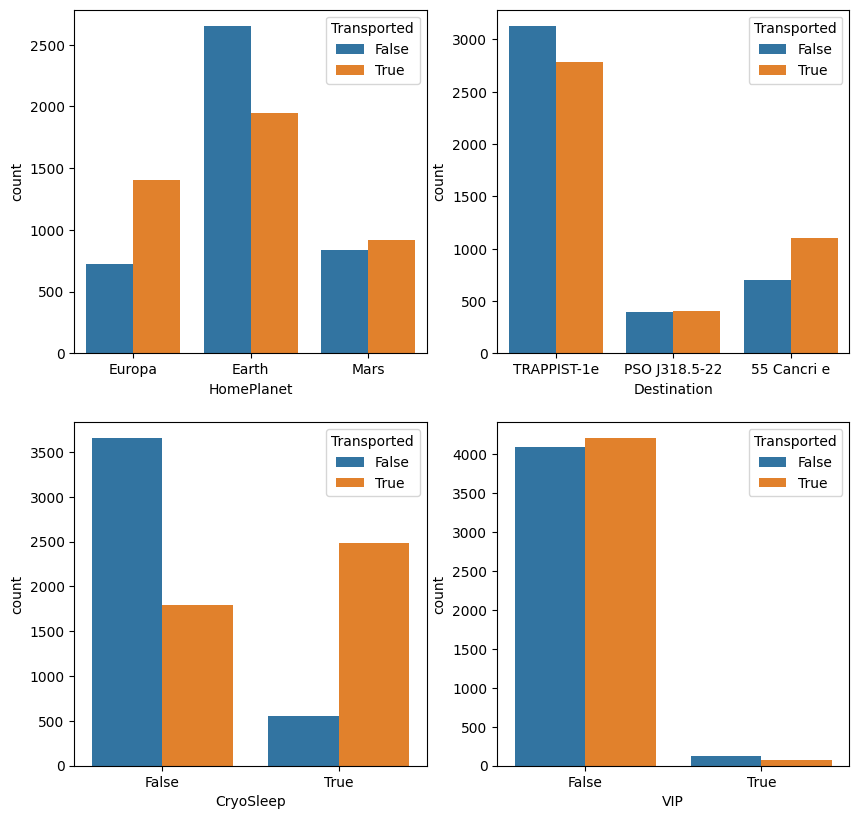

In [10]:
figure, ax = plt.subplots(2,2, figsize=(10,4))
plt.subplots_adjust(top = 2)
sns.countplot(train_df_clean, x = 'HomePlanet',hue='Transported', ax=ax[0,0])
sns.countplot(train_df_clean, x = 'Destination',hue='Transported', ax=ax[0,1])
sns.countplot(train_df_clean, x = 'CryoSleep',hue='Transported', ax=ax[1,0])
sns.countplot(train_df_clean, x = 'VIP',hue='Transported', ax=ax[1,1])

**High correlation of CyroSleep and Transported**

**Convert data CyroSleep and VIP to numeric**


In [11]:
order_cols = list(train_df_clean.columns)
order_cols.remove('CryoSleep')
order_cols.insert(5,'CryoSleep')
order_cols.remove('Age')
order_cols.insert(5,'Age')

train_df_clean = train_df_clean[order_cols]
train_df_clean.head()

,HomePlanet,Cabin,Destination,VIP,CryoSleep,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,B/0/P,TRAPPIST-1e,False,False,39.0,0.0,0.0,0.0,0.0,0.0,False
1,Earth,F/0/S,TRAPPIST-1e,False,False,24.0,109.0,9.0,25.0,549.0,44.0,True
2,Europa,A/0/S,TRAPPIST-1e,True,False,58.0,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,A/0/S,TRAPPIST-1e,False,False,33.0,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,F/1/S,TRAPPIST-1e,False,False,16.0,303.0,70.0,151.0,565.0,2.0,True


# Part 2: Data Engineering

**Fill empty data with mode for catagories and mean for numerical**


In [12]:
for index in range (0,5):
    column_name = train_df_clean.columns[index]    
    train_df_clean[column_name] = train_df_clean[column_name].fillna(train_df_clean[column_name].mode()[0])
    
for index in range (5,12):
    column_name = train_df_clean.columns[index]    
    train_df_clean[column_name] = train_df_clean[column_name].fillna(train_df_clean[column_name].mode()[0])
    
# Change booleans to numbers
train_df_clean['VIP'] = train_df_clean['VIP'].astype(int)
train_df_clean['CryoSleep'] = train_df_clean['CryoSleep'].astype(int)
train_df_clean['Transported'] = train_df_clean['Transported'].astype(int)
train_df_clean.head()

,HomePlanet,Cabin,Destination,VIP,CryoSleep,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,B/0/P,TRAPPIST-1e,0,0,39.0,0.0,0.0,0.0,0.0,0.0,0
1,Earth,F/0/S,TRAPPIST-1e,0,0,24.0,109.0,9.0,25.0,549.0,44.0,1
2,Europa,A/0/S,TRAPPIST-1e,1,0,58.0,43.0,3576.0,0.0,6715.0,49.0,0
3,Europa,A/0/S,TRAPPIST-1e,0,0,33.0,0.0,1283.0,371.0,3329.0,193.0,0
4,Earth,F/1/S,TRAPPIST-1e,0,0,16.0,303.0,70.0,151.0,565.0,2.0,1


**Work with the "Cabin" column and transform into 3 columns of "Cab_Deck", "Cab_Number", and "Cab_Side"**

In [13]:
train_df_clean[["Cab_Deck", "Cab_Number", "Cab_Side"]] = train_df_clean['Cabin'].str.split('/', expand = True)
train = train_df_clean.drop(columns=['Cabin'])
train.head()

,HomePlanet,Destination,VIP,CryoSleep,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cab_Deck,Cab_Number,Cab_Side
0,Europa,TRAPPIST-1e,0,0,39.0,0.0,0.0,0.0,0.0,0.0,0,B,0,P
1,Earth,TRAPPIST-1e,0,0,24.0,109.0,9.0,25.0,549.0,44.0,1,F,0,S
2,Europa,TRAPPIST-1e,1,0,58.0,43.0,3576.0,0.0,6715.0,49.0,0,A,0,S
3,Europa,TRAPPIST-1e,0,0,33.0,0.0,1283.0,371.0,3329.0,193.0,0,A,0,S
4,Earth,TRAPPIST-1e,0,0,16.0,303.0,70.0,151.0,565.0,2.0,1,F,1,S


**Make a correlation plot of all the numerical data.**

<Axes: >

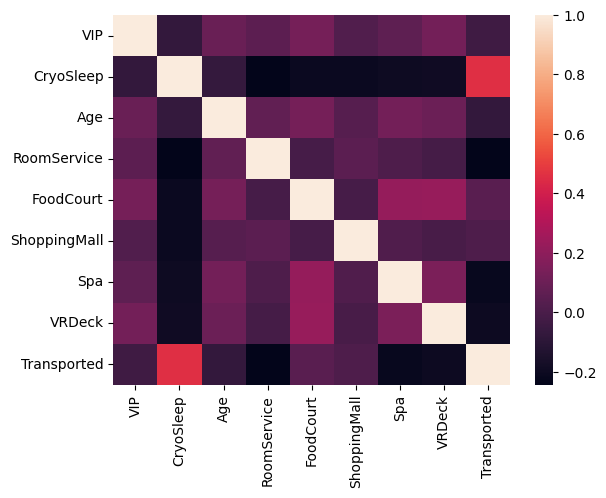

In [14]:
corr_data = train[['VIP','CryoSleep','Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Transported']].corr()
sns.heatmap(corr_data)

**The Correlation of CryoSleep and Transported is pretty high again from this view**

<Axes: xlabel='CryoSleep', ylabel='Age'>

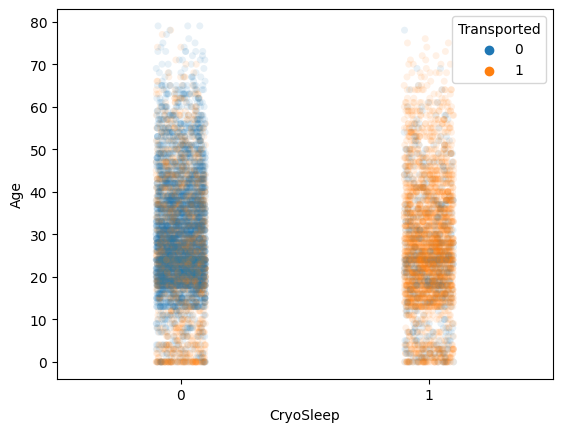

In [15]:
sns.stripplot(data= train,x='CryoSleep',y= 'Age', hue='Transported',alpha=0.1)

**Convert the catagory values in 'dummy' values for input to the training model**

In [16]:
train['Cab_Number'] = train['Cab_Number'].astype(int)
cat_columns = ['HomePlanet','Destination','Cab_Deck','Cab_Side']
train_final = pd.get_dummies(train, columns = cat_columns)
# convert the T and F to ints
convert_bool_to_int = lambda x: int(x) if isinstance(x,bool) else x
train_final = train_final.applymap(convert_bool_to_int)

# Place Transported as final column
new_order = list(train_final.columns)
new_order.remove('Transported')
new_order.insert(25,'Transported')
train_final = train_final[new_order]
train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   VIP                        8693 non-null   int64  
 1   CryoSleep                  8693 non-null   int64  
 2   Age                        8693 non-null   float64
 3   RoomService                8693 non-null   float64
 4   FoodCourt                  8693 non-null   float64
 5   ShoppingMall               8693 non-null   float64
 6   Spa                        8693 non-null   float64
 7   VRDeck                     8693 non-null   float64
 8   Cab_Number                 8693 non-null   int64  
 9   HomePlanet_Earth           8693 non-null   int64  
 10  HomePlanet_Europa          8693 non-null   int64  
 11  HomePlanet_Mars            8693 non-null   int64  
 12  Destination_55 Cancri e    8693 non-null   int64  
 13  Destination_PSO J318.5-22  8693 non-null   int64

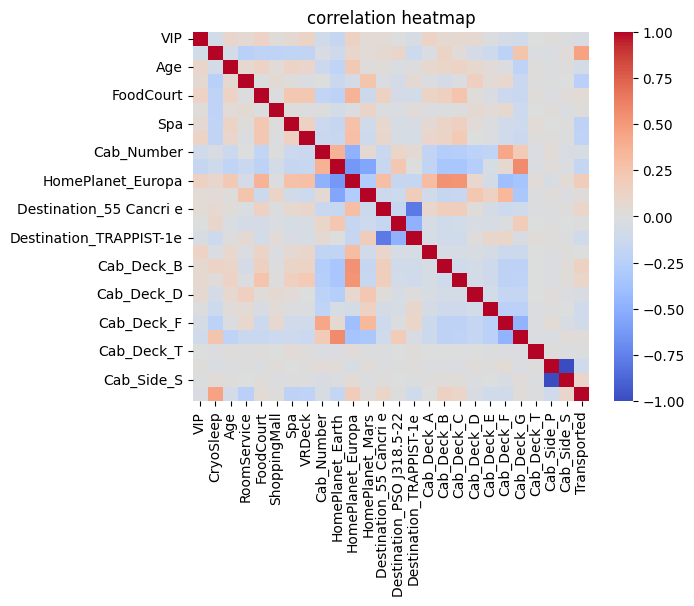

In [17]:
# Correlation all the data
corr_data = train_final.corr()
sns.heatmap(corr_data, cmap='coolwarm')
plt.title('correlation heatmap')
plt.show()

Cab_side S and P are just the inverse of each other so drop one.

In [18]:
train_final.drop(columns=['Cab_Side_P'])

,VIP,CryoSleep,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cab_Number,HomePlanet_Earth,...,Cab_Deck_A,Cab_Deck_B,Cab_Deck_C,Cab_Deck_D,Cab_Deck_E,Cab_Deck_F,Cab_Deck_G,Cab_Deck_T,Cab_Side_S,Transported
0,0,0,39.0,0.0,0.0,0.0,0.0,0.0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,24.0,109.0,9.0,25.0,549.0,44.0,0,1,...,0,0,0,0,0,1,0,0,1,1
2,1,0,58.0,43.0,3576.0,0.0,6715.0,49.0,0,0,...,1,0,0,0,0,0,0,0,1,0
3,0,0,33.0,0.0,1283.0,371.0,3329.0,193.0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,0,0,16.0,303.0,70.0,151.0,565.0,2.0,1,1,...,0,0,0,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,1,0,41.0,0.0,6819.0,0.0,1643.0,74.0,98,0,...,1,0,0,0,0,0,0,0,0,0
8689,0,1,18.0,0.0,0.0,0.0,0.0,0.0,1499,1,...,0,0,0,0,0,0,1,0,1,0
8690,0,0,26.0,0.0,0.0,1872.0,1.0,0.0,1500,1,...,0,0,0,0,0,0,1,0,1,1
8691,0,0,32.0,0.0,1049.0,0.0,353.0,3235.0,608,0,...,0,0,0,0,1,0,0,0,1,0


# Part 3: Repeat Data treatment for test data

In [19]:
test_df = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")
test_df.head()
pass_id = test_df['PassengerId']

percentage_of_missing_train = ( train_df.isnull().sum() / train_df.count() * 100)
percentage_of_missing_test = ( test_df.isnull().sum() / test_df.count() * 100)
print(percentage_of_missing_train - percentage_of_missing_test)
# missing data is similar in its levels

Age            -0.071493
Cabin          -0.051232
CryoSleep       0.337417
Destination    -0.059918
FoodCourt      -0.390946
HomePlanet      0.290561
Name            0.107689
PassengerId     0.000000
RoomService     0.171702
ShoppingMall    0.106326
Spa            -0.268171
Transported          NaN
VIP             0.168295
VRDeck          0.304341
dtype: float64


In [20]:
test_df2 = test_df.drop(columns = ['PassengerId', 'Name'])

order_cols = list(test_df2.columns)
order_cols.remove('CryoSleep')
order_cols.insert(5,'CryoSleep')
order_cols.remove('Age')
order_cols.insert(5,'Age')
test_df_clean = test_df2[order_cols]

# Fill the na values
for index in range (0,5):
    column_name = test_df_clean.columns[index]    
    test_df_clean[column_name] = test_df_clean[column_name].fillna(test_df_clean[column_name].mode()[0])
    
for index in range (5,11):
    column_name = test_df_clean.columns[index]    
    test_df_clean[column_name] = test_df_clean[column_name].fillna(test_df_clean[column_name].mode()[0])
    
# Change booleans to numbers
test_df_clean['VIP'] = test_df_clean['VIP'].astype(int)
test_df_clean['CryoSleep'] = test_df_clean['CryoSleep'].astype(int)

test_df_clean[["Cab_Deck", "Cab_Number", "Cab_Side"]] = test_df_clean['Cabin'].str.split('/', expand = True)
test = test_df_clean.drop(columns=['Cabin'])

# 
test['Cab_Number'] = test['Cab_Number'].astype(int)
test_final = pd.get_dummies(test, columns = cat_columns)
# convert the T and F to ints
convert_bool_to_int = lambda x: int(x) if isinstance(x,bool) else x
test_final = test_final.applymap(convert_bool_to_int)
test_final.drop(columns=['Cab_Side_P'])
# Make sure the organization if the same for the train and test
test_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   VIP                        4277 non-null   int64  
 1   CryoSleep                  4277 non-null   int64  
 2   Age                        4277 non-null   float64
 3   RoomService                4277 non-null   float64
 4   FoodCourt                  4277 non-null   float64
 5   ShoppingMall               4277 non-null   float64
 6   Spa                        4277 non-null   float64
 7   VRDeck                     4277 non-null   float64
 8   Cab_Number                 4277 non-null   int64  
 9   HomePlanet_Earth           4277 non-null   int64  
 10  HomePlanet_Europa          4277 non-null   int64  
 11  HomePlanet_Mars            4277 non-null   int64  
 12  Destination_55 Cancri e    4277 non-null   int64  
 13  Destination_PSO J318.5-22  4277 non-null   int64

# Part 4: Train model(s)

**Split the Transported column off for training.**

In [21]:
X = train_final.drop(columns=['Transported'])
y = train_final['Transported']

In [22]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

test_rfclf = RandomForestClassifier(n_estimators = 50)
test_rfclf.fit(x_train, y_train)
test_rfclf.score(x_test, y_test)
# confusion_matrix(test_clf.predict(x_test),y_test)

0.8062104657849338

In [23]:
from sklearn.ensemble import GradientBoostingClassifier
test_gbclf = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0, max_depth=1, random_state=0)
test_gbclf.fit(x_train, y_train)
test_gbclf.score(x_test, y_test)

0.8027602070155262

In [24]:
from sklearn.ensemble import HistGradientBoostingClassifier 
test_gbclf = HistGradientBoostingClassifier()
test_gbclf.fit(x_train, y_train)
test_gbclf.score(x_test, y_test)

0.8136860264519838

In [25]:
from sklearn.ensemble import BaggingClassifier
test_bclf = BaggingClassifier(n_estimators=50, random_state=0)
test_bclf.fit(x_train, y_train)
test_bclf.score(x_test, y_test)

0.7924094307073031

**Run a RandomForestClassifier model training**

In [26]:
rf_clf = RandomForestClassifier(n_estimators = 50)
rf_clf.fit(X,y)

RandomForestClassifier(n_estimators=50)

In [27]:
#hgbrf_clf = HistGradientBoostingClassifier()
#hgbrf_clf.fit(X,y)

### Using the RandomForestClassifier as it has have the best results from kaggle's scoring on the test data

In [28]:
y_test = rf_clf.predict(test_final)
# Check ids and predictions are the same length
len(y_test)-len(pass_id)

0

# Part 5: Output

In [29]:
pred_df = pd.DataFrame({'PassengerId': pass_id})
pred_df['Transported'] = [bool(x) for x in y_test]
pred_df


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,False
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [30]:
pred_df.to_csv('submission.csv', index= False)